<a href="https://colab.research.google.com/github/MaximilianSti/segmentation_with_unet/blob/master/final_seg_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

#Imports

In [ ]:
import keras
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
import skimage
import skimage.io as io
from skimage.metrics import structural_similarity, mean_squared_error
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import skeletonize
from skimage.metrics import contingency_table

#Loading Images

In [ ]:
img_size = (512,512)
division_factor = 4
div_per_image = division_factor*division_factor
train_img_number = 39
test_img_number = 9
input_size = img_size + (1,)

xtrain_dir = "/content/drive/MyDrive/SegmentUConvNet/xtrain/"
ytrain_dir = "/content/drive/MyDrive/SegmentUConvNet/ytrain/"
xtest_dir = "/content/drive/MyDrive/SegmentUConvNet/xtest/"
ytest_dir = "/content/drive/MyDrive/SegmentUConvNet/ytest/"

xtrain_img_paths = sorted([os.path.join(xtrain_dir, fname) for fname in os.listdir(xtrain_dir) if fname.endswith(".tif")])
ytrain_img_paths = sorted([os.path.join(ytrain_dir, fname) for fname in os.listdir(ytrain_dir) if fname.endswith(".tif")])
xtest_img_paths = sorted([os.path.join(xtest_dir, fname) for fname in os.listdir(xtest_dir) if fname.endswith(".tif")])
ytest_img_paths = sorted([os.path.join(ytest_dir, fname) for fname in os.listdir(ytest_dir) if fname.endswith(".tif")])

Training data

In [ ]:
xtrain_images = np.zeros((div_per_image*train_img_number,) + input_size, dtype="float32") 
for idx, path in enumerate(xtrain_img_paths):
    img = img_to_array(Image.open(path))/65535.
    for i in range(division_factor):
        for j in range(division_factor):
            xtrain_images[idx*div_per_image+i*division_factor+j] = img[i*512:i*512+512,j*512:j*512+512]

ytrain_images = np.zeros((div_per_image*train_img_number,) + input_size, dtype="uint8") 
for idx, path in enumerate(ytrain_img_paths):
    img = img_to_array(Image.open(path))/65535.
    for i in range(division_factor):
        for j in range(division_factor):
            ytrain_images[idx*div_per_image+i*division_factor+j] = img[i*512:i*512+512,j*512:j*512+512]
    ytrain_images[ytrain_images >= 0.1] = 1.
    ytrain_images[ytrain_images < 0.1] = 0.

trainx = xtrain_images
trainy = ytrain_images
"""
for idx, ximage in enumerate(trainx):
  ximg = np.flip(ximage)
  trainx = np.append(trainx,[ximg],axis=0)
  yimg = np.flip(trainy[idx])
  trainy = np.append(trainy,[yimg],axis=0) 

"""

'\nfor idx, ximage in enumerate(trainx):\n  ximg = np.flip(ximage)\n  trainx = np.append(trainx,[ximg],axis=0)\n  yimg = np.flip(trainy[idx])\n  trainy = np.append(trainy,[yimg],axis=0) \n\n'

In [ ]:
rows, cols = img_size[0], img_size[1]

src_cols = np.linspace(0, cols, 20)
src_rows = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
dst_cols = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T

tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

#out = warp(image, tform, output_shape=(rows, cols))

for idx in range(10):
  ximg = warp(trainx[idx],tform,output_shape=(rows, cols,1),cval=1.)
  trainx = np.append(trainx,[ximg],axis=0)
  yimg = warp(trainy[idx],tform,output_shape=(rows, cols,1),cval=1.)
  trainy = np.append(trainy,[yimg],axis=0) 


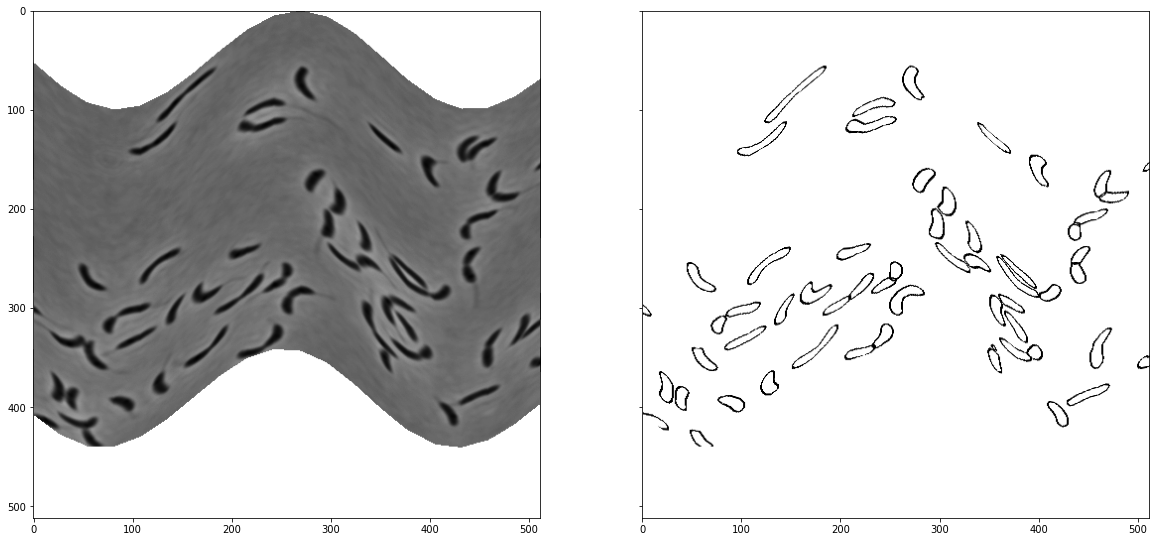

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(array_to_img(trainx[-4]),cmap="gray")
ax[1].imshow(array_to_img(trainy[-4]),cmap="gray")
plt.show()


Test data

In [ ]:
xtest_images = np.zeros((div_per_image*test_img_number,) + input_size, dtype="float32") 
for idx, path in enumerate(xtest_img_paths):
    img = img_to_array(Image.open(path))/65535.
    for i in range(division_factor):
        for j in range(division_factor):
            xtest_images[idx*div_per_image+i*division_factor+j] = img[i*512:i*512+512,j*512:j*512+512]

ytest_images = np.zeros((div_per_image*test_img_number,) + input_size, dtype="uint8")
real_images = []
for idx, path in enumerate(ytest_img_paths):
    img = img_to_array(Image.open(path))/65535.
    img[img>= 0.5] = 1.
    img[img<0.5] = 0.
    for i in range(division_factor):
        for j in range(division_factor):
            ytest_images[idx*div_per_image+i*division_factor+j] = img[i*512:i*512+512,j*512:j*512+512]
    real_images.append(img)

#U-net model

In [ ]:
def unet(input_size):
    inputs = keras.Input(shape = input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3)) #conv7
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = keras.Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

mymodel = unet(input_size)
opt = tf.keras.optimizers.RMSprop(lr = 1e-3)
loss_function = "binary_crossentropy"
mymodel.compile(optimizer=opt, loss=loss_function)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#Training the model

In [ ]:
batchsize = 4
stepsperepoch = 2*div_per_image*train_img_number / (10*batchsize)

callbacks = [keras.callbacks.ModelCheckpoint("segmentation.h5", save_best_only=True)]

hist = mymodel.fit(trainx,trainy, batch_size = batchsize,steps_per_epoch = stepsperepoch,epochs=1,verbose = 1,callbacks=callbacks)

31/31 [==============================] - 2149s 69s/step - loss: 0.0354


#Testing the model and saving outputs

In [ ]:
results = mymodel.predict(xtest_images,batch_size = 8,verbose = 1)

In [ ]:
save_path = "/content/drive/MyDrive/SegmentUConvNet/predicts"
predicted_images = []
threshold = 0.8

for idx in range(9):
  img_name = ytest_img_paths[idx][:-4].split("/")[-1]
  results_image = np.zeros((2048,2048,1), dtype="float32")
  for i in range(4):
    for j in range(4):
      results_image[i*512:i*512+512,j*512:j*512+512] = results[idx*16+i*4+j]  
  print(results_image.min(),results_image.max())
  results_image[results_image >= threshold] = 1.
  results_image[results_image < threshold] = 0.
  io.imsave(os.path.join(save_path,img_name+"_predict.tif"),skimage.img_as_ubyte(results_image))
  predicted_images.append(results_image)

Creating difference images

In [ ]:
save_path = "/content/drive/MyDrive/SegmentUConvNet/losses"
loss_images = []
skel_loss_images =[]
skel_real_images = []
skel_predicted_images = []

for idx in range(9):
  img_name = ytest_img_paths[idx][:-4].split("/")[-1]
  loss_image = np.zeros((2048,2048,1), dtype="float32")
  predicted_image = predicted_images[idx]
  real_image = real_images[idx]
  loss_image = (real_image - predicted_image +1.) /2.

  predicted_image = (1. - skeletonize(1. - predicted_image) + 255.)/512
  predicted_image[predicted_image < 0.1] = 0
  predicted_image[predicted_image >= 0.1] = 1.
  real_image = (1. - skeletonize(1. - real_image) + 255.)/512
  real_image[real_image < 0.1] = 0.
  real_image[real_image >= 0.1] = 1.
  skel_loss_image = (real_image - predicted_image +1.) /2.

  loss_images.append(loss_image)
  skel_loss_images.append(skel_loss_image)
  skel_real_images.append(real_image)
  skel_predicted_images.append(predicted_image)
  io.imsave(os.path.join(save_path,img_name+"_predict.tif"),skimage.img_as_ubyte(loss_image))
  io.imsave(os.path.join(save_path,img_name+"_skeletonized_predict.tif"),skimage.img_as_ubyte(skel_loss_image))

Metrics for quantification

In [ ]:
"original images"
for i, yimg in enumerate(real_images):
  a = contingency_table(yimg.astype(int),predicted_images[i].astype(int))
  ssim = structural_similarity(yimg,predicted_images[idx],multichannel=True)
  mse = mean_squared_error(yimg,predicted_images[idx])
  print("original "+str(i)+"\n",a)
  print("ssim "+str(ssim))
  print("mse "+str(mse)+"\n")

In [ ]:
"skeletonized images"
for i, yimg in enumerate(skel_real_images):
  a = contingency_table(yimg.astype(int),skel_predicted_images[i].astype(int))
  ssim = structural_similarity(yimg,skel_predicted_images[idx],multichannel=True)
  mse = mean_squared_error(yimg,skel_predicted_images[idx])
  print("skeletonized "+str(i)+"\n",a)
  print("ssim "+str(ssim))
  print("mse "+str(mse)+"\n")